# Consistency check

Here I check that the time evolution obtained from TEBD is the same as the one from exact diagonalization of the Hamiltonian.

The system is made of $L$ spins with periodic boundary condisitons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product

In [7]:
### PROBLEM PARAMETERS
L = 10        # chain length
omega = 1     # Rabi frequency
V = 0.1       # B-S interaction strength
V_ = 1        # subsystem interaction strength
beta = 0.1    # inverse temperature for the bath
dt = 0.1      # time step
T = 10        # total time of the simulation

dims = [2]*L # overall space of L qbits

## Exact simulation

In [17]:
def initial_cond(type):
    '''Function returning the density matrix for
    a given initial condition
    
    Args
    ----
        type : char
            select the type of initial condition
    '''        
    if type == 'up':  
        print('Initial state as |up,...,up>\n')   #(see basis for Pauli operators)
        rho = np.zeros((2**L, 2**L))
        rho[0][0] = 1
        
    elif type == 'updown':
        print('Initial state as |up,down,up,down...>\n')   #(see basis for Pauli operators)
        up = np.array([[1, 0]]).T
        down = np.array([[0, 1]]).T
        
        psi = np.kron(up, down)
        
        for i in range(L-2):
            if i%2==0:
                psi = np.kron(psi, up)
            else:
                psi = np.kron(psi, down)
        
        rho = psi@psi.T
    else:
        raise ValueError('input type mus be either \'up\' of \'updown\'')
                
    return rho

In [9]:
### BUILDING THE HAMILTONIAN

# fisrt I build the operators
X = qu.pauli('X')
Z = qu.pauli('Z')
nn_op = (1 + Z)/2 & (1 + Z)/2

print(f'Building Hamiltonian for L={L}')
# the hamiltonian
H_Rabi = sum(qu.ikron(X, dims, i) for i in range(L))
H_int_b = sum(qu.ikron(nn_op, dims, (i, i+1)) for i in range(2, L-1))
H_int_s = sum(qu.pkron(nn_op, dims, (i, j)) for i,j in zip([L-1,0,1], [0,1,2]))

H = (omega/2)*H_Rabi + V_*H_int_b + V*H_int_s

# diagonalization
e, U = la.eig(H, isherm=True)

print('done :)')

Building Hamiltonian for L=10
done :)


In [10]:
### BUILDING THE OBSERVABLES

observables_ex = {}
results_ex = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results_ex[key] = []
    observables_ex[key] = qu.ikron(qu.pauli(ob1)&qu.pauli(ob2), dims, (0, 1))

# dropping the identity
observables_ex.pop('I1I2')
results_ex.pop('I1I2')

### THE SIMULATION

# initial conditions
rho = initial_cond('up')

# smarter way to calculate the coherence vector:
rho_tilde = np.conj(U.T) @ rho @ U                  # matrix

pauli_tilde = {}
t = []
for key in observables_ex.keys():
    pauli_tilde[key] = np.conj(U.T) @ observables_ex[key] @ U
    
for i in range(1, int(T/dt)):
    ee = np.exp(-1j*e*dt*i)  # diagonalized hamiltonian
    rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)
        
    trace = lambda key: ( (pauli_tilde[key]@rho_in).trace() / rho_tilde.trace()).real
    for key in results_ex.keys():
        results_ex[key].append(trace(key))
        
    t.append( dt*i )
        
print("finished Time = %s" % T)
    
print('done')

Initial state as |up,...,up>

finished Time = 10
done


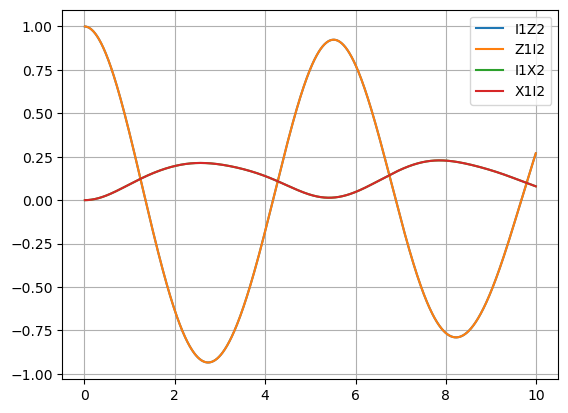

In [11]:
keys = results_ex.keys()
keys = ['I1Z2', 'Z1I2', 'I1X2', 'X1I2']

for key in keys:
    plt.plot(t, results_ex[key], label=key)
plt.legend()
plt.grid()

### Simulation using TEBD

In [12]:
### BUILDING THE HAMILTONIAN
# tebd do not require an MPO, but a specification of the local interacting parts of the Hamiltonian

# fisrt I build the operators
X = qu.pauli('X')
Z = qu.pauli('Z')
nn_op = (1 + Z)/2 & (1 + Z)/2

H1 = {i: (omega/2)*X for i in range(L)}
H2 = {None: nn_op, (L-1, 0): V*nn_op, (0, 1): V*nn_op, (1, 2): V*nn_op}

H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)


### BUILDING THE SPIN CHAIN

# binary version of the initial state
# 0 : up
# 1 : down
binary = '01'
for i in range(L-2):
    if i%2==0:
        binary += '0'
    else:
        binary += '1'
binary = '0'*L
print(f'|{binary}>')
        
# turning the state into a MPS
psi = qtn.MPS_computational_state(binary, cyclic=True)
psi.show()  # prints ascii representation of state


|0000000000>
 1 1 1 1 1 1 1 1 1 1 1 
+─●─●─●─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │ │ │ │  


In [13]:
### THE SIMULATION

# first I build the observables
observables_tebd = {}
results = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results[key] = []
    # MPO
    #operators = [qu.pauli(ob1), qu.pauli(ob2)] + [qu.pauli('I')]*(L-2)
    #observables_tebd[key] = qtn.MPO_product_operator(operators, cyclic=True)
    # gate
    observables_tebd[key] = qu.pauli(ob1) & qu.pauli(ob2)

# dropping the identity
observables_tebd.pop('I1I2')
results.pop('I1I2')
    
# create the object
tebd = qtn.TEBD(psi, H)

# I can either set a timestep or a tolerance and the timestep is calculated accordingly
tebd.split_opts['cutoff'] = 1e-10

# generate the state at each time in t (same as exact simulation)
#     and target error 1e-3 for whole evolution
t_ = np.linspace(0, T, 100)
keys = results.keys()
for psit in tebd.at_times(t_, tol=1e-3):
    #for key in keys:
        #results[key].append(qtn.expec_TN_1D(psit.H, observables_tebd[key], psit))
        #results[key].append(psit.H @ psit.gate(observables_tebd[key], (0, 1)))
    results['I1Z2'].append(psit.H @ psit.gate(qu.pauli('Z'), 1))
    results['I1X2'].append(psit.H @ psit.gate(qu.pauli('X'), 1))
    results['Z1I2'].append(psit.H @ psit.gate(qu.pauli('Z'), 0))
    results['X1I2'].append(psit.H @ psit.gate(qu.pauli('X'), 0))
    results['Z1Z2'].append(psit.H @ psit.gate(qu.pauli('Z')&qu.pauli('Z'), (0,1)))
    results['Z1X2'].append(psit.H @ psit.gate(qu.pauli('Z')&qu.pauli('X'), (0,1)))

t=10, max-bond=133: 100%|###################################################################################################################################################################################################| 100/100 [00:39<00:00,  2.54it/s]


In [14]:
print(f'Check for the normalization: {tebd.pt.H @ tebd.pt}\n')
#print('Check for energy conservation:\n')
#print(f'  start {qtn.expec_TN_1D(psi.H, H, psi)}')
#print(f'  start {qtn.expec_TN_1D(tebd.pt.H, H, tebd.pt)}')

Check for the normalization: (0.9999999987418655-7.983059284442283e-17j)



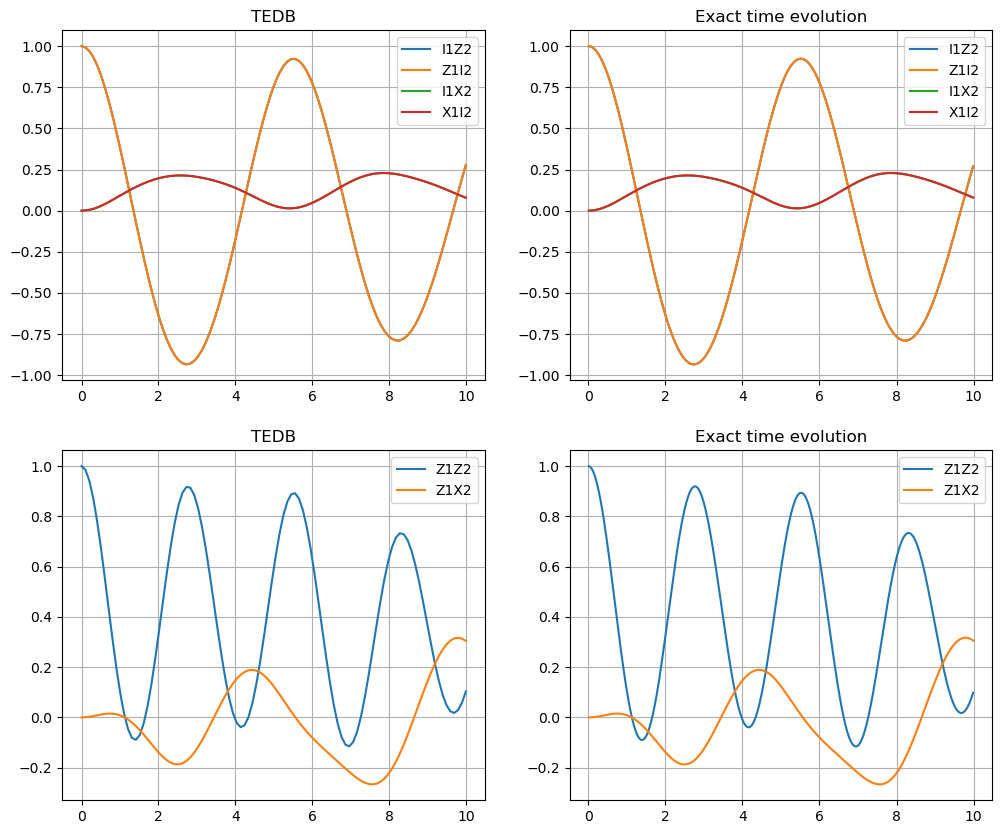

In [20]:
keys = observables_tebd.keys()
keys = ['I1Z2', 'Z1I2', 'I1X2', 'X1I2']

fig, ax = plt.subplots(2, 2, figsize=(12,10))
for key in keys:
    ax[0][0].plot(t_, results[key], label=key)
    ax[0][1].plot(t, results_ex[key], label=key)    
ax[0][0].set_title('TEDB')
ax[0][1].set_title('Exact time evolution')

keys = ['Z1Z2', 'Z1X2']
for key in keys:
    ax[1][0].plot(t_, results[key], label=key)
    ax[1][1].plot(t, results_ex[key], label=key)
ax[1][0].set_title('TEDB')
ax[1][1].set_title('Exact time evolution')

for i in range(2):
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend()

plt.savefig('./pictures/consistency_check.pdf')